In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import shap
from sklearn.inspection import permutation_importance

import warnings 
warnings.filterwarnings('ignore')



In [2]:
# 1. Load Dataset
file_path = '/Users/radhikapanchal/Downloads/dataset_excavate.csv'
df = pd.read_csv(file_path)
print(df.shape)
print("Missing Values:\n", df.isnull().sum())

# 2. Data Preprocessing
# Renaming columns for consistency
df = df.rename(columns={'μ': 'mu', 'μĀ': 'mu_A', 'μB̄': 'mu_B'})
df_viz = df.copy()

# Create Binary Target
df['target'] = (df['PBE band gap'] > 0.5).astype(int)

# Drop 'PBE band gap' for classification
df = df.drop(columns=['PBE band gap'])

# Drop 'functional group' as it is categorical with high cardinality
X = df.drop(columns=['target', 'functional group'])
y = df['target']

(5152, 38)
Missing Values:
 functional group    0
A                   0
A_OS                0
A'                  0
A'_OS               0
A_HOMO-             0
A_HOMO+             0
A_IE-               0
A_IE+               0
A_LUMO-             0
A_LUMO+             0
A_X-                0
A_X+                0
A_Z_radii-          0
A_Z_radii+          0
A_e_affin-          0
A_e_affin+          0
Bi                  0
B_OS                0
B'                  0
B'_OS               0
B_HOMO-             0
B_HOMO+             0
B_IE-               0
B_IE+               0
B_LUMO-             0
B_LUMO+             0
B_X-                0
B_X+                0
B_Z_radii-          0
B_Z_radii+          0
B_e_affin-          0
B_e_affin+          0
PBE band gap        0
μ                   0
μĀ                  0
μ𝐵 ̅                0
t                   0
dtype: int64


In [3]:
# Feature Engineering
X["orbital_gap_A"] = X["A_LUMO+"] - X["A_HOMO+"]
X["orbital_gap_B"] = X["B_LUMO+"] - X["B_HOMO+"]
X["IE_gap_A"] = X["A_IE+"] - X["A_IE-"]
X["IE_gap_B"] = X["B_IE+"] - X["B_IE-"]
X["EA_diff"] = abs(X["A_e_affin+"] - X["B_e_affin+"])
X["charge_stability"] = abs(X["A_OS"] + X["A'_OS"] + X["B_OS"] + X["B'_OS"] - 6)

# Encoding Categorical Variables
label_encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le


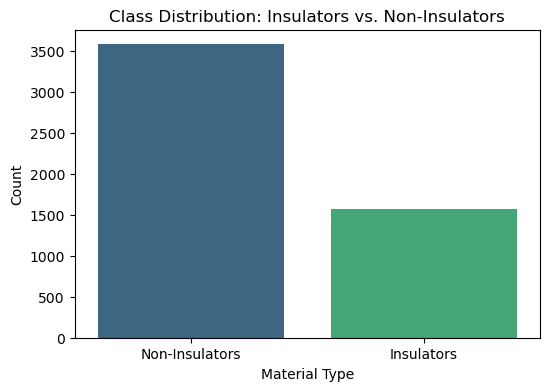

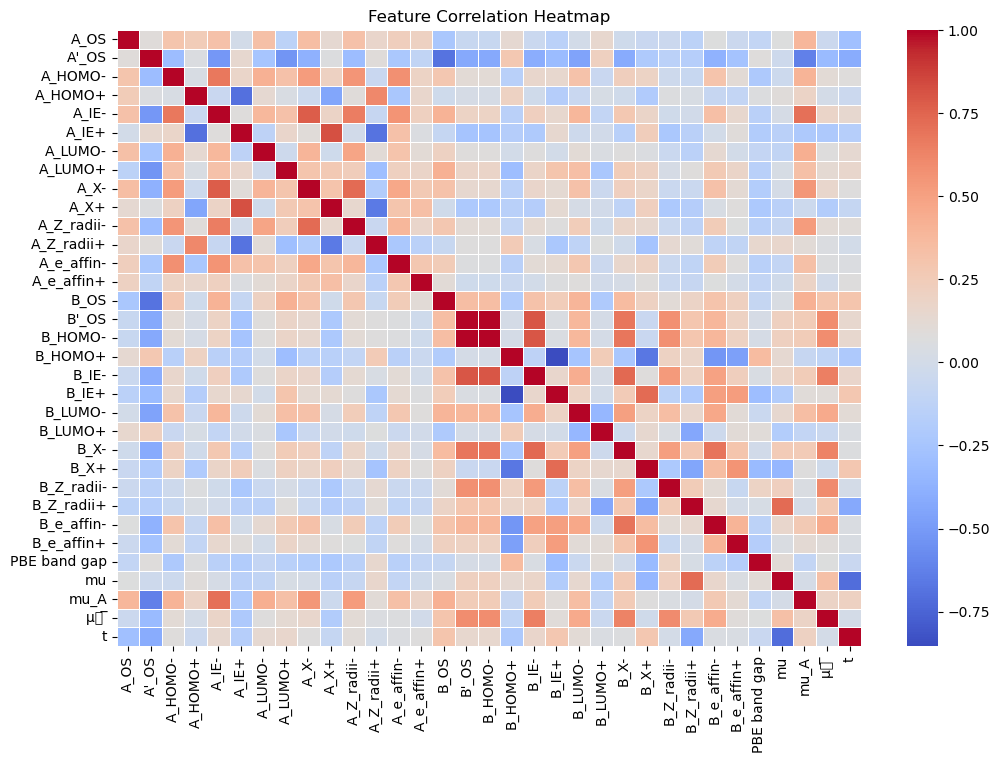

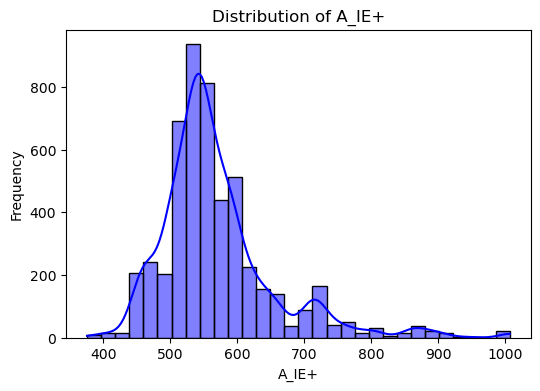

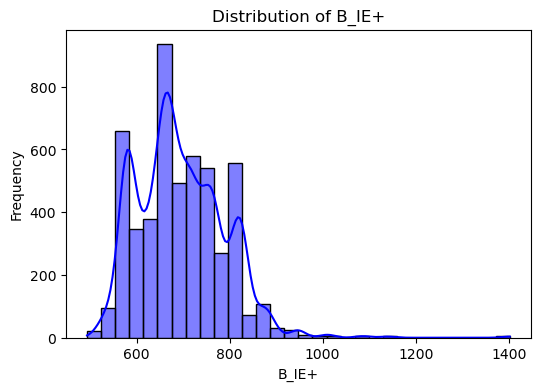

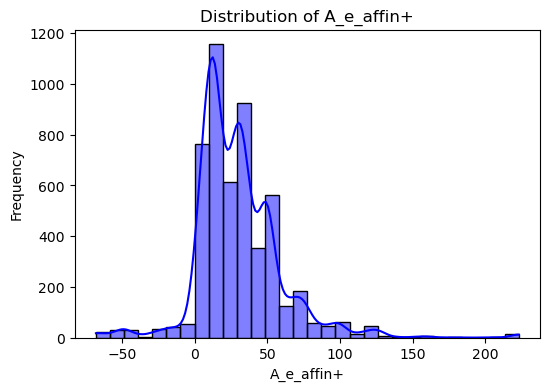

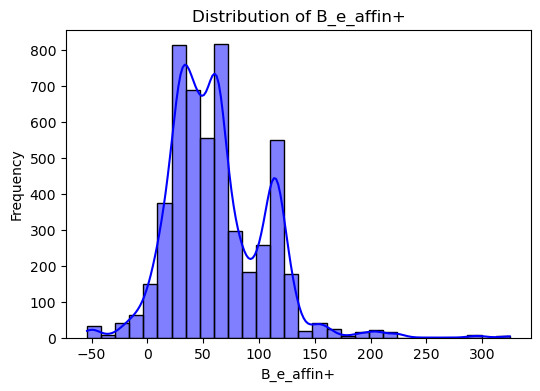

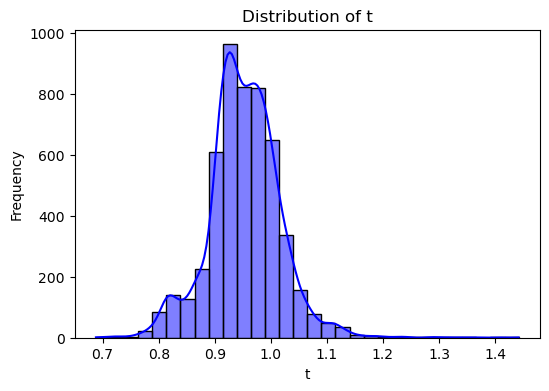

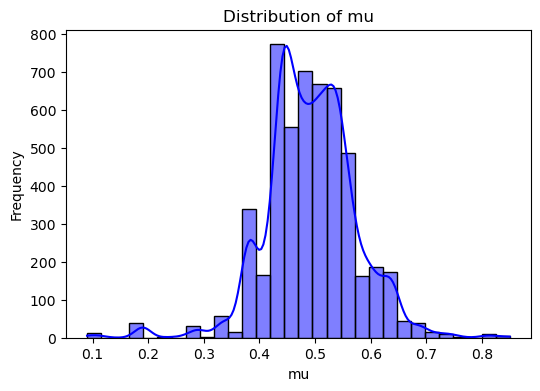

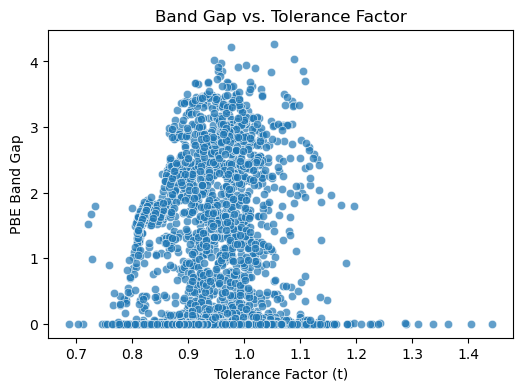

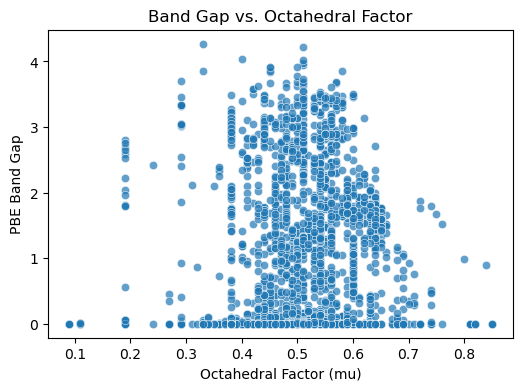

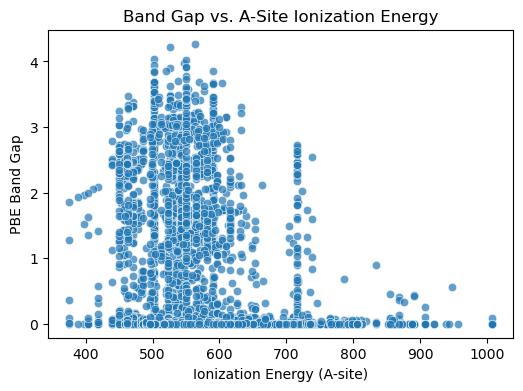

In [4]:
# 3. Data Analysis & Visualization 
# Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df["target"], palette="viridis")
plt.xticks([0, 1], ["Non-Insulators", "Insulators"])
plt.xlabel("Material Type")
plt.ylabel("Count")
plt.title("Class Distribution: Insulators vs. Non-Insulators")
plt.show()

# Feature Correlation Heatmap (Only Numeric Columns)
numeric_df = df_viz.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
corr = numeric_df.corr()
sns.heatmap(corr, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Feature Distributions
selected_features = ["A_IE+", "B_IE+", "A_e_affin+", "B_e_affin+", "t", "mu"]
for feature in selected_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_viz[feature], kde=True, bins=30, color="blue")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {feature}")
    plt.show()

# Band Gap Trends 
plt.figure(figsize=(6, 4))
sns.scatterplot(x=df_viz["t"], y=df_viz["PBE band gap"], alpha=0.7)
plt.xlabel("Tolerance Factor (t)")
plt.ylabel("PBE Band Gap")
plt.title("Band Gap vs. Tolerance Factor")
plt.show()

plt.figure(figsize=(6, 4))
sns.scatterplot(x=df_viz["mu"], y=df_viz["PBE band gap"], alpha=0.7)
plt.xlabel("Octahedral Factor (mu)")
plt.ylabel("PBE Band Gap")
plt.title("Band Gap vs. Octahedral Factor")
plt.show()

plt.figure(figsize=(6, 4))
sns.scatterplot(x=df_viz["A_IE+"], y=df_viz["PBE band gap"], alpha=0.7)
plt.xlabel("Ionization Energy (A-site)")
plt.ylabel("PBE Band Gap")
plt.title("Band Gap vs. A-Site Ionization Energy")
plt.show()

In [5]:

# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Train XGBoost with Best Parameters
best_params = {
    'n_estimators': 351,
    'learning_rate': 0.029149694572413305,
    'max_depth': 10,
    'min_child_weight': 1,
    'gamma': 0.1534508837536619,
    'subsample': 0.9581748956266246,
    'colsample_bytree': 0.529814632151196,
    'reg_alpha': 0.0006081629368625436,
    'reg_lambda': 0.00047682596672995466
}

xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    tree_method="hist",
    **best_params
)

xgb_model.fit(X_train, y_train)

# 6. Model Evaluation
y_pred = xgb_model.predict(X_test)
train_preds = xgb_model.predict(X_train)

print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred))
print("\nXGBoost Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("XGBoost Training Accuracy: {:.4f}".format(accuracy_score(y_train, train_preds)))



XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       716
           1       0.95      0.87      0.91       315

    accuracy                           0.94      1031
   macro avg       0.95      0.92      0.93      1031
weighted avg       0.94      0.94      0.94      1031


XGBoost Accuracy: 0.9447
XGBoost Training Accuracy: 1.0000


In [6]:
X_train.columns

Index(['A', 'A_OS', 'A'', 'A'_OS', 'A_HOMO-', 'A_HOMO+', 'A_IE-', 'A_IE+',
       'A_LUMO-', 'A_LUMO+', 'A_X-', 'A_X+', 'A_Z_radii-', 'A_Z_radii+',
       'A_e_affin-', 'A_e_affin+', 'Bi', 'B_OS', 'B'', 'B'_OS', 'B_HOMO-',
       'B_HOMO+', 'B_IE-', 'B_IE+', 'B_LUMO-', 'B_LUMO+', 'B_X-', 'B_X+',
       'B_Z_radii-', 'B_Z_radii+', 'B_e_affin-', 'B_e_affin+', 'mu', 'mu_A',
       'μ𝐵 ̅', 't', 'orbital_gap_A', 'orbital_gap_B', 'IE_gap_A', 'IE_gap_B',
       'EA_diff', 'charge_stability'],
      dtype='object')

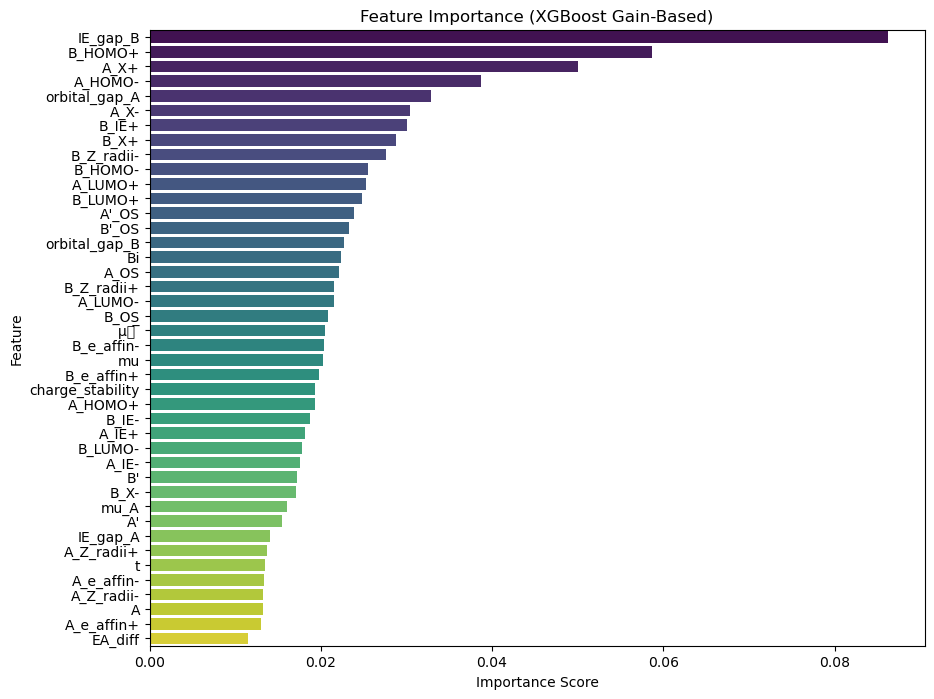

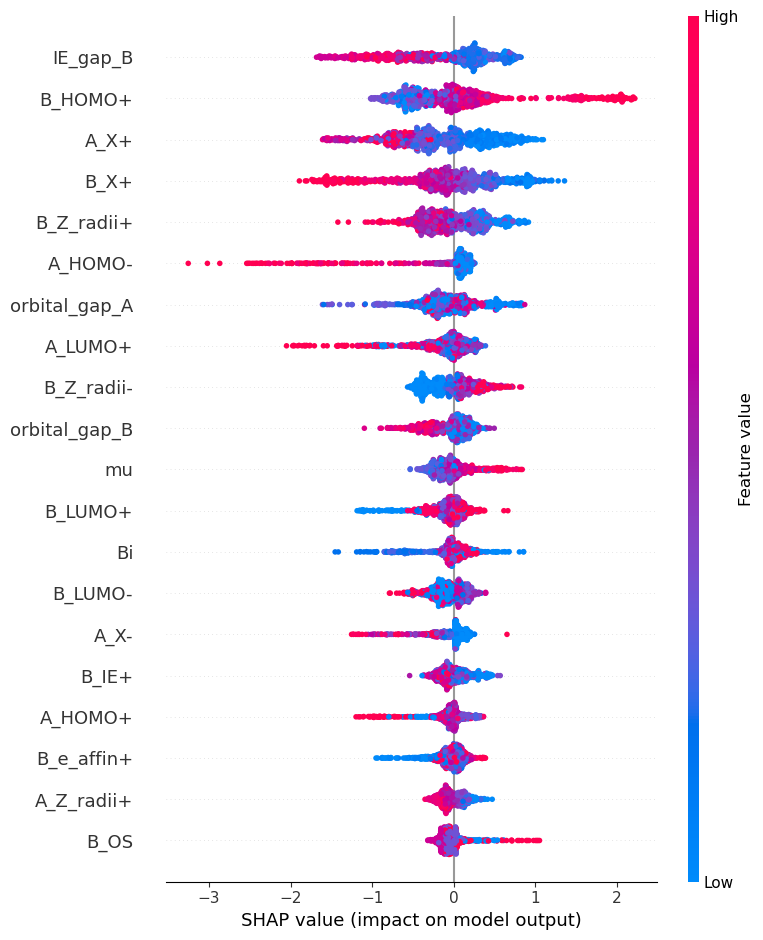

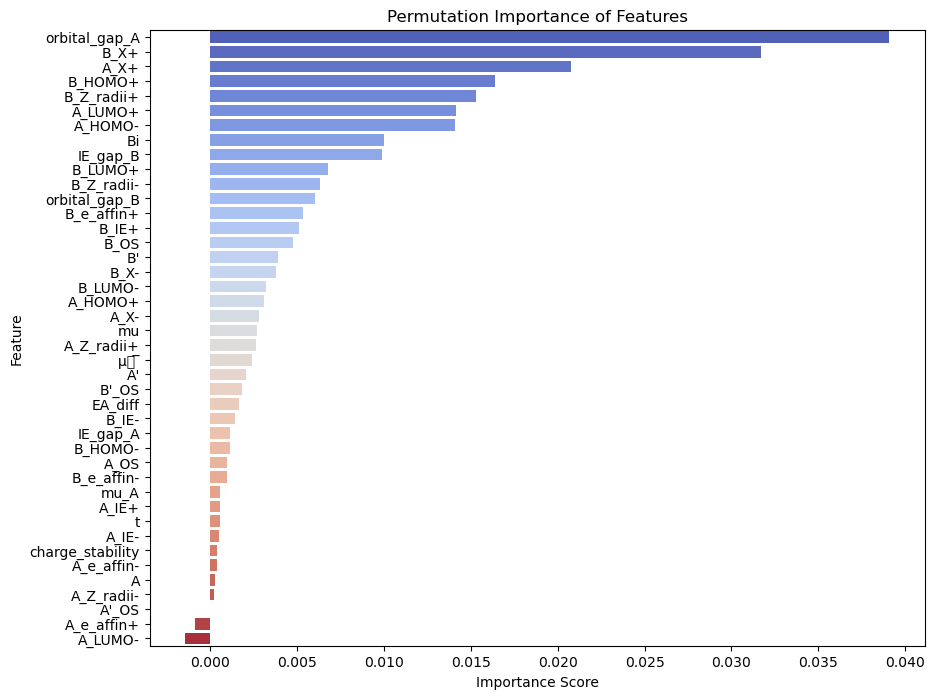

In [7]:
# Ensure Numeric Data for Analysis
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')
X_train.fillna(X_train.median(), inplace=True)
X_test.fillna(X_test.median(), inplace=True)

# Feature Importance (XGBoost Gain-based)
# Get feature importances and sort them in descending order
importances = xgb_model.feature_importances_
features = X_train.columns

# Create a DataFrame and sort
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by="Importance", ascending=False)

# Plot sorted feature importances
plt.figure(figsize=(10, 8))
sns.barplot(
    x=feat_imp_df['Importance'], 
    y=feat_imp_df['Feature'], 
    palette="viridis"
)
plt.title("Feature Importance (XGBoost Gain-Based)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


# SHAP Analysis for Feature Impact
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# SHAP Summary Plot (Global Feature Influence)
shap.summary_plot(shap_values, X_test)

# Permutation Importance (Validation)
perm_importance = permutation_importance(xgb_model, X_test, y_test, n_repeats=10, random_state=42)
perm_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': perm_importance.importances_mean}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=perm_df['Importance'], y=perm_df['Feature'], palette="coolwarm")
plt.title("Permutation Importance of Features")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings 
warnings.filterwarnings('ignore')

# 1. Load Data & Preprocessing
file_path = '/Users/radhikapanchal/Downloads/dataset_excavate.csv'
df = pd.read_csv(file_path)

# Rename columns for consistency
df = df.rename(columns={'μ': 'mu', 'μĀ': 'mu_A', 'μB̄': 'mu_B'})

# Filter only the insulators (PBE band gap > 0.5 eV)
df_insulators = df[df['PBE band gap'] > 0.5].copy()

# Separate target and features (target is the continuous band gap value)
y = df_insulators['PBE band gap']
X = df_insulators.drop(columns=['PBE band gap', 'functional group'])

# 2. Feature Engineering
# Create new features based on domain knowledge
X["orbital_gap_A"] = X["A_LUMO+"] - X["A_HOMO+"]
X["orbital_gap_B"] = X["B_LUMO+"] - X["B_HOMO+"]
X["adjusted_tolerance"] = X["t"] / (X["mu"] + 1e-8)
X["IE_gap_A"] = X["A_IE+"] - X["A_IE-"]
X["IE_gap_B"] = X["B_IE+"] - X["B_IE-"]
X["EA_diff"] = abs(X["A_e_affin+"] - X["B_e_affin+"])
X["charge_stability"] = abs(X["A_OS"] + X["A'_OS"] + X["B_OS"] + X["B'_OS"] - 6)

# Identify categorical features for CatBoost
cat_features = X.select_dtypes(include=['object']).columns.tolist()

# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Train Final Model with Best Parameters

final_params = {
    'iterations': 1456,
    'learning_rate': 0.06970226947721213,
    'depth': 6,
    'l2_leaf_reg': 1,
    'bagging_temperature': 0.4507524543046699
}

final_model = CatBoostRegressor(
    loss_function='RMSE',
    random_seed=42,
    verbose=0,
    **final_params
)

final_model.fit(X_train, y_train, cat_features=cat_features)

# 5. Model Evaluation
y_pred = final_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Final Model Evaluation on Test Set:")
print("CatBoost Regression RMSE: {:.4f}".format(rmse))
print("CatBoost Regression R2 Score: {:.4f}".format(r2))


Final Model Evaluation on Test Set:
CatBoost Regression RMSE: 0.2585
CatBoost Regression R2 Score: 0.9017


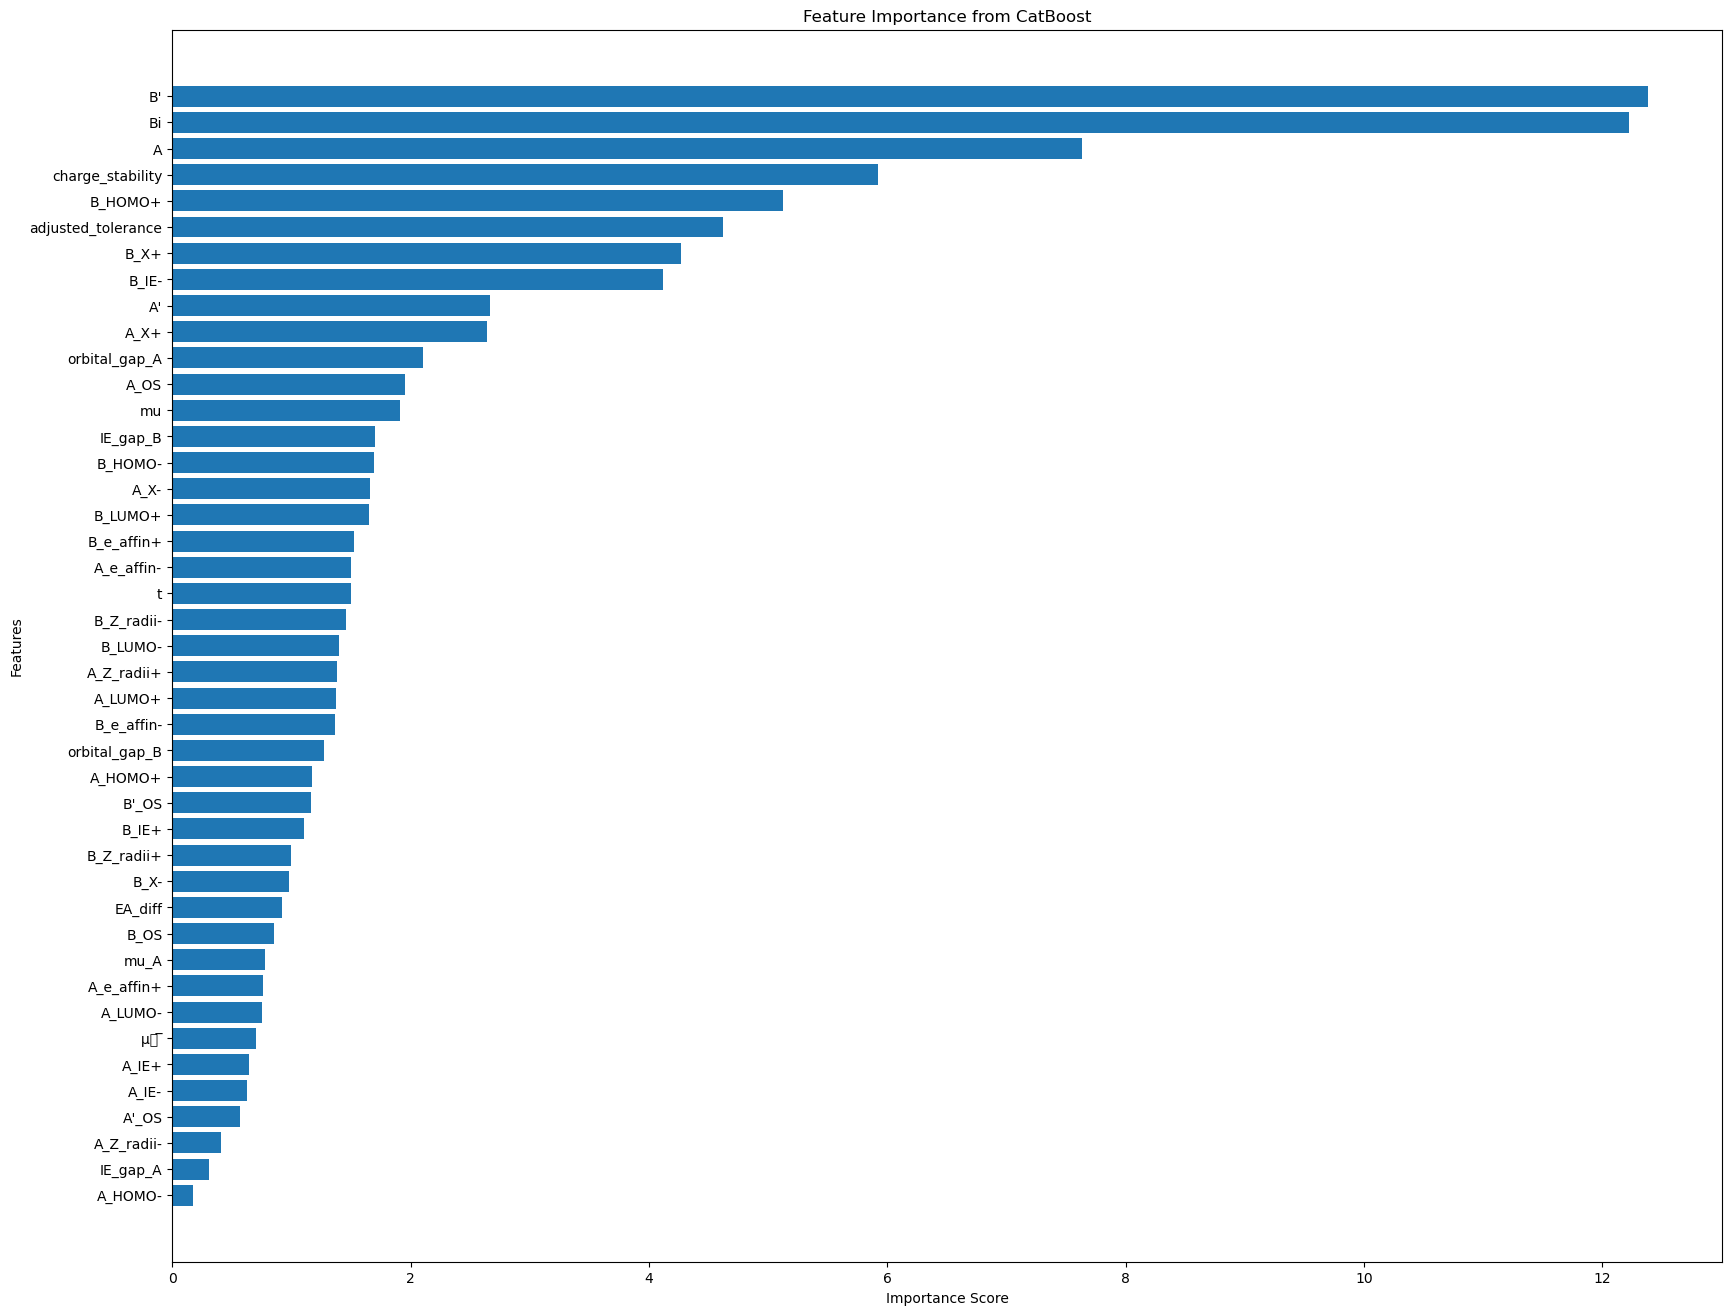

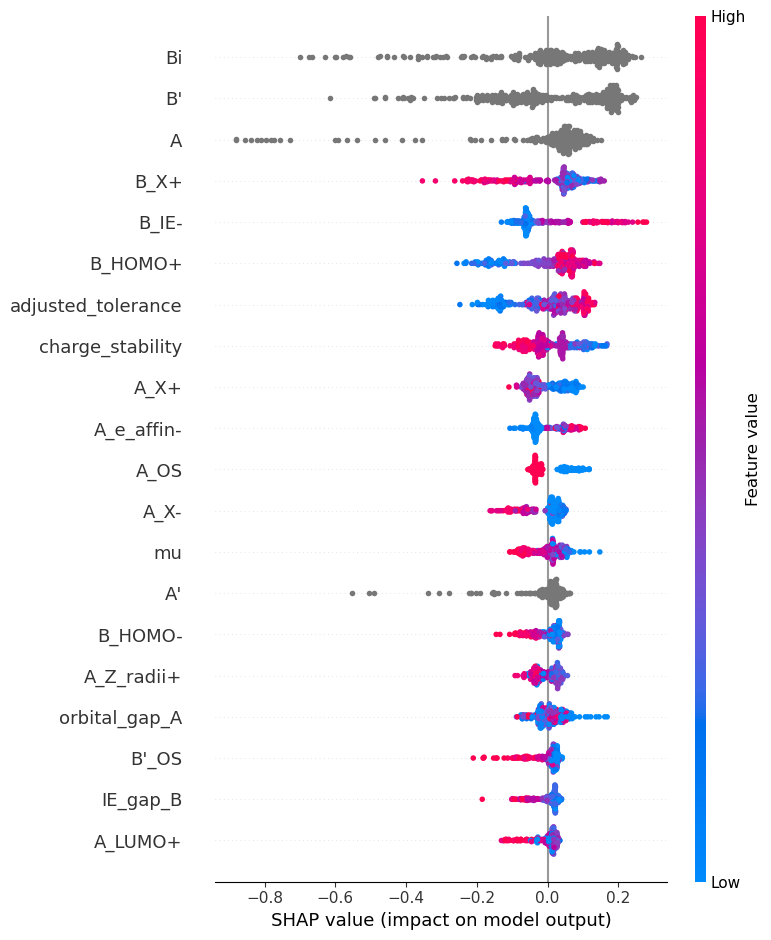

In [9]:
feature_importances = final_model.get_feature_importance()
feature_names = X.columns


# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]

# Feature Importance Plot
plt.figure(figsize=(20, 16))
plt.barh([feature_names[i] for i in sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance from CatBoost")
plt.gca().invert_yaxis()
plt.show()


# SHAP Analysis
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)